# CHIPS-CVN Classification Notebook

Import all the required modules and call the gpu_setup utility

In [1]:
import time

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix
from sklearn.metrics import classification_report
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE
import ROOT
from root_numpy import fill_hist

import chipscvn.utils as utils
import chipscvn.config as config
import chipscvn.data as data
import chipscvn.models as models
import chipscvn.evaluators as evaluators
utils.gpu_setup()  # Setup the GPU's
ROOT.gStyle.SetOptStat(0)

Welcome to JupyROOT 6.18/04
---  3 Physical GPUs, 3 Logical GPUs ---


Load the trained model from the configuration and run the classification evaluator...

In [2]:
conf = config.get("config/classification.yml")
config.setup_dirs(conf, False)
evaluator = utils.get_evaluator(conf)
evaluator.run()
evaluator.cut_summary()

--- Running Evaluation ---

--- running inference...

--- combining outputs...

--- applying cuts...

--- calculating weights...

--- Num-> Nuel:2731, Numu:5968, NC:2120, Cosmic:6414

--- Weights-> Nuel:0.0147, Numu:0.2838, NC:0.2666, Cosmic:113.4743

--- Done (took 81.79696011543274 seconds) ---

Nuel CC QE: 2731, Survived: 0.913584767484438

Nuel CC nQE: 5968, Survived: 0.9066689008042895

Numu CC QE: 2120, Survived: 0.8764150943396226

Numu CC nQE: 6414, Survived: 0.9009978172747116

NC: 4099, Survived: 0.5647718955842889

Cosmic: 10668, Survived: 0.20172478440194977



2020-03-12 08:58:52.130447: I tensorflow/stream_executor/platform/default/dso_loader.cc:44] Successfully opened dynamic library libcublas.so.10
2020-03-12 08:58:52.411839: I tensorflow/stream_executor/platform/default/dso_loader.cc:44] Successfully opened dynamic library libcudnn.so.7


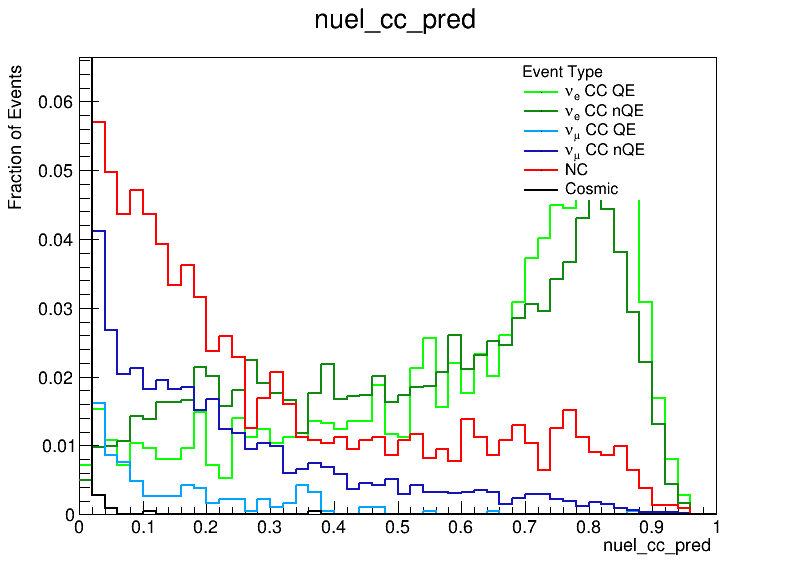

In [3]:
hists, leg = evaluator.make_cat_plot('nuel_cc_pred', 50, 0, 1, 'norm', True)
c = ROOT.TCanvas("c", 'nuel_cc_pred', 800, 600)
for hist in hists:
    hist.Draw("HISTSAME")
leg.Draw()
c.Draw()

Warning in <TROOT::Append>: Replacing existing TH1: h_0 (Potential memory leak).
Warning in <TROOT::Append>: Replacing existing TH1: h_1 (Potential memory leak).
Warning in <TROOT::Append>: Replacing existing TH1: h_2 (Potential memory leak).
Warning in <TROOT::Append>: Replacing existing TH1: h_3 (Potential memory leak).
Warning in <TROOT::Append>: Replacing existing TH1: h_4 (Potential memory leak).
Warning in <TROOT::Append>: Replacing existing TH1: h_5 (Potential memory leak).
Warning in <TCanvas::Constructor>: Deleting canvas with same name: c


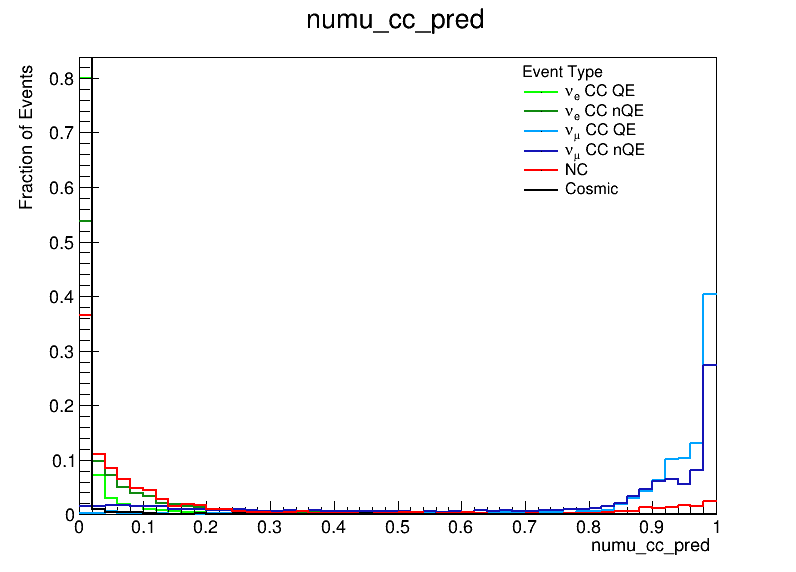

In [4]:
hists, leg = evaluator.make_cat_plot('numu_cc_pred', 50, 0, 1, 'norm', True)
c = ROOT.TCanvas("c", 'numu_cc_pred', 800, 600)
for hist in hists:
    hist.Draw("HISTSAME")
leg.Draw()
c.Draw()

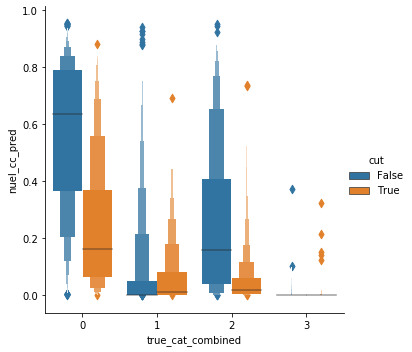

In [5]:
sns.catplot(x="true_cat_combined", y="nuel_cc_pred", kind="boxen", hue="cut", data=evaluator.events)
plt.show()

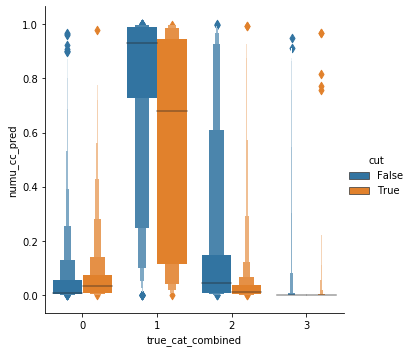

In [6]:
sns.catplot(x="true_cat_combined", y="numu_cc_pred", kind="boxen", hue="cut", data=evaluator.events)
plt.show()

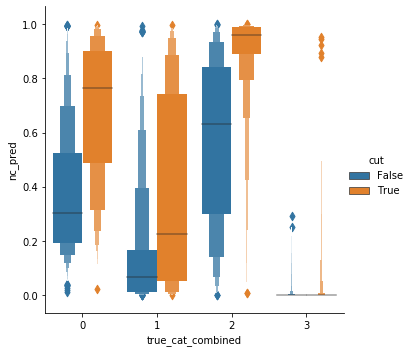

In [7]:
sns.catplot(x="true_cat_combined", y="nc_pred", kind="boxen", hue="cut", data=evaluator.events)
plt.show()

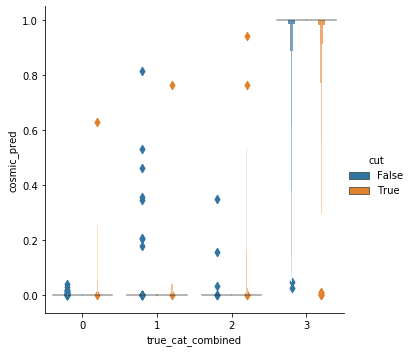

In [8]:
sns.catplot(x="true_cat_combined", y="cosmic_pred", kind="boxen", hue="cut", data=evaluator.events)
plt.show()

In [9]:
def pred_classifier(event):
    combined_values = [event['nuel_cc_pred'], event['numu_cc_pred'], event['nc_pred'], event['cosmic_pred']]
    return np.asarray(combined_values).argmax()

evaluator.events['pred_cat_combined'] = evaluator.events.apply(pred_classifier, axis=1)
evaluator.events["pred_cat_combined"] = evaluator.events["pred_cat_combined"].astype('int')

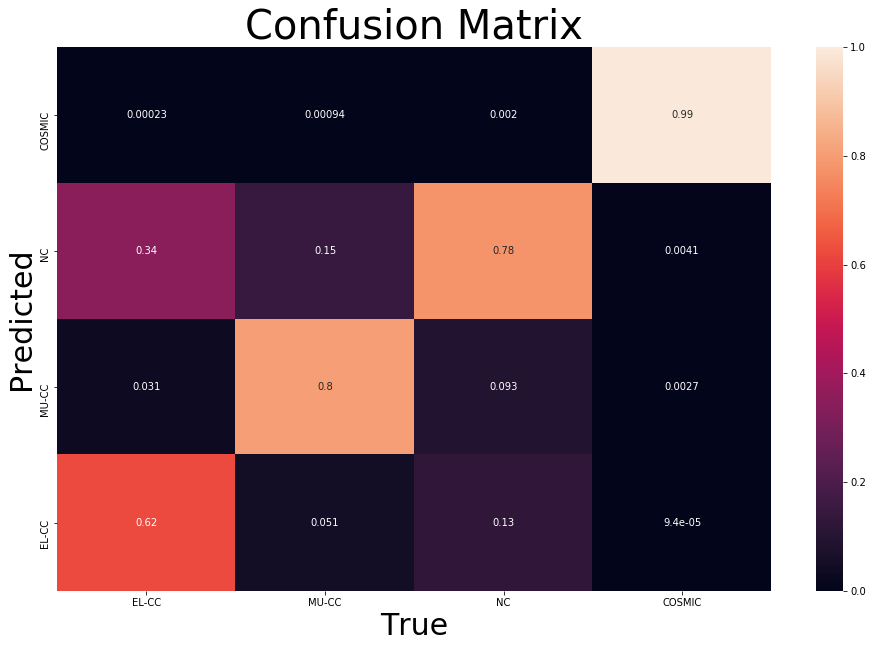

In [10]:
matrix = confusion_matrix(evaluator.events["true_cat_combined"], evaluator.events["pred_cat_combined"], normalize='true')
matrix_transpose = np.rot90(matrix, 1)
df_cm = pd.DataFrame(matrix_transpose, 
                     index = ["COSMIC", "NC", "MU-CC", "EL-CC"],
                     columns = ["EL-CC", "MU-CC", "NC", "COSMIC"])
plt.figure(figsize=(16,10))
sns.heatmap(df_cm, annot=True, vmin=0.0, vmax=1.0)
plt.title('Confusion Matrix', fontsize = 40) # title with fontsize 20
plt.xlabel('True', fontsize = 30) # x-axis label with fontsize 15
plt.ylabel('Predicted', fontsize = 30) # y-axis label with fontsize 15
plt.show()

In [11]:
axis_labels = ["EL-CC", "MU-CC", "NC", "COSMIC"]
print(classification_report(evaluator.events["true_cat_combined"], evaluator.events["pred_cat_combined"], target_names=axis_labels))

              precision    recall  f1-score   support

       EL-CC       0.85      0.62      0.72      8699
       MU-CC       0.91      0.80      0.85      8534
          NC       0.43      0.78      0.55      4099
      COSMIC       1.00      0.99      1.00     10668

    accuracy                           0.81     32000
   macro avg       0.80      0.80      0.78     32000
weighted avg       0.86      0.81      0.83     32000



In [12]:
pca = PCA(n_components=3)
pca_result = pca.fit_transform(np.stack(evaluator.events["dense"], axis=0))
print('Explained variation per principal component: {}'.format(pca.explained_variance_ratio_))

Explained variation per principal component: [0.9681515  0.01535564 0.00330645]


In [13]:
# Add in the labels
pca_df = pd.DataFrame(pca_result)
pca_df['true_cat_combined'] = evaluator.events['true_cat_combined']
pca_df.rename(columns={0: "PCA1", 1: "PCA2", 2: "PCA3"}, inplace=True)
pca_df.head()

,PCA1,PCA2,PCA3,true_cat_combined
0,-29.854958,4.581154,2.710243,2
1,2.772745,-12.770830,-2.715901,3
2,-30.370363,3.650275,-1.723564,0
3,-29.764969,4.227549,2.175540,1
4,2.998893,-14.417286,3.773814,3


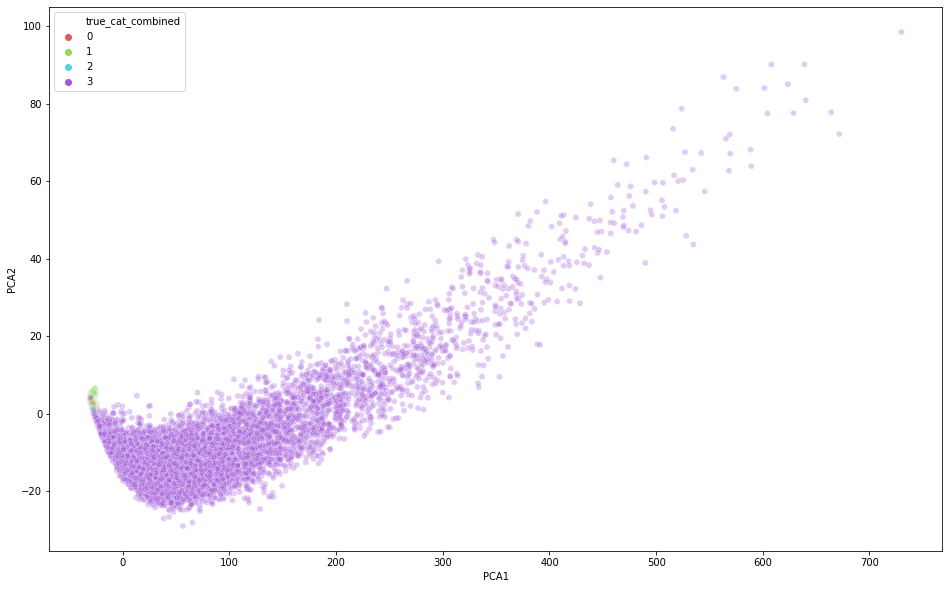

In [14]:
plt.figure(figsize=(16,10))
sns.scatterplot(
    x="PCA1", y="PCA2",
    hue="true_cat_combined",
    palette=sns.color_palette("hls", 4),
    data=pca_df,
    legend="full",
    alpha=0.3
)
plt.show()

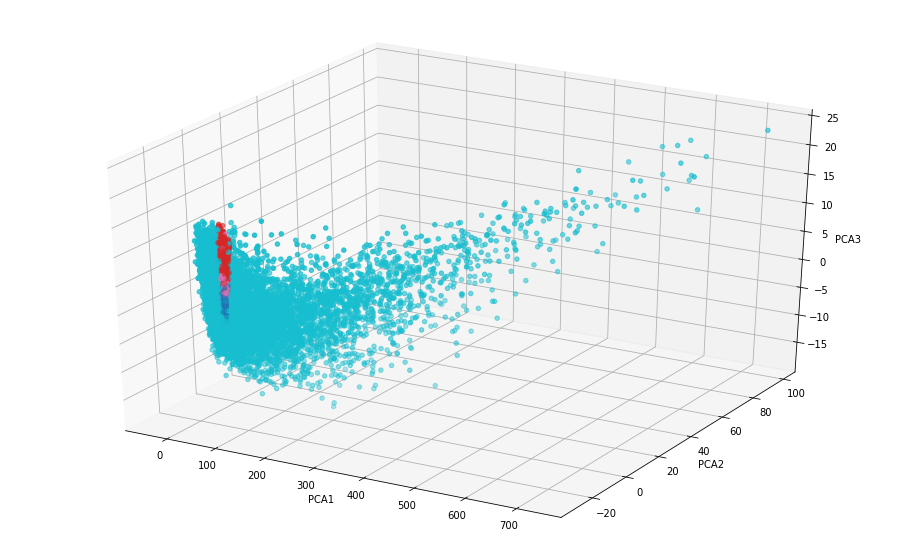

In [15]:
ax = plt.figure(figsize=(16,10)).gca(projection='3d')
ax.scatter(
    xs=pca_df["PCA1"], 
    ys=pca_df["PCA2"], 
    zs=pca_df["PCA3"], 
    c=pca_df["true_cat_combined"], 
    cmap='tab10'
)
ax.set_xlabel('PCA1')
ax.set_ylabel('PCA2')
ax.set_zlabel('PCA3')
plt.show()

In [16]:
N = 10000
events_subset = evaluator.events[:N]

In [17]:
time_start = time.time()
tsne = TSNE(n_components=2, verbose=1, perplexity=40, n_iter=300)
tsne_results = tsne.fit_transform(np.stack(events_subset["dense"], axis=0))
print('t-SNE done! Time elapsed: {} seconds'.format(time.time()-time_start))

[t-SNE] Computing 121 nearest neighbors...
[t-SNE] Indexed 10000 samples in 0.839s...
[t-SNE] Computed neighbors for 10000 samples in 43.396s...
[t-SNE] Computed conditional probabilities for sample 1000 / 10000
[t-SNE] Computed conditional probabilities for sample 2000 / 10000
[t-SNE] Computed conditional probabilities for sample 3000 / 10000
[t-SNE] Computed conditional probabilities for sample 4000 / 10000
[t-SNE] Computed conditional probabilities for sample 5000 / 10000
[t-SNE] Computed conditional probabilities for sample 6000 / 10000
[t-SNE] Computed conditional probabilities for sample 7000 / 10000
[t-SNE] Computed conditional probabilities for sample 8000 / 10000
[t-SNE] Computed conditional probabilities for sample 9000 / 10000
[t-SNE] Computed conditional probabilities for sample 10000 / 10000
[t-SNE] Mean sigma: 1.813557
[t-SNE] KL divergence after 250 iterations with early exaggeration: 74.596802
[t-SNE] KL divergence after 300 iterations: 2.504209
t-SNE done! Time elapsed

In [18]:
tsne_df = pd.DataFrame(tsne_results)
tsne_df['true_cat_combined'] = events_subset['true_cat_combined']
tsne_df.rename(columns={0: "tsne-2d-one", 1: "tsne-2d-two"}, inplace=True)
tsne_df.head()

,tsne-2d-one,tsne-2d-two,true_cat_combined
0,1.453834,3.429133,2
1,4.595826,9.953456,3
2,-2.234121,-3.300169,0
3,1.889396,1.165898,1
4,3.627269,7.411245,3


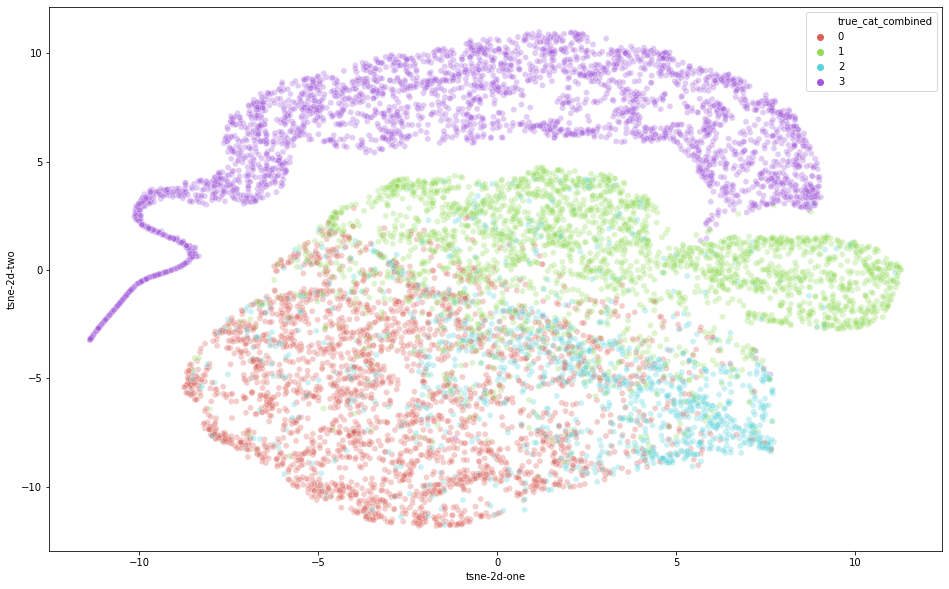

In [19]:
plt.figure(figsize=(16,10))
sns.scatterplot(
    x="tsne-2d-one", y="tsne-2d-two",
    hue="true_cat_combined",
    palette=sns.color_palette("hls", 4),
    data=tsne_df,
    legend="full",
    alpha=0.3
)

In [20]:
pca_50 = PCA(n_components=50)
pca_result_50 = pca_50.fit_transform(np.stack(evaluator.events["dense"], axis=0))
print('Cumulative explained variation for 50 principal components: {}'.format(np.sum(pca_50.explained_variance_ratio_)))
pca_50_df = pd.DataFrame(pca_result_50)

Cumulative explained variation for 50 principal components: 0.9988844394683838


In [21]:
N = 10000
pca_50_subset = pca_50_df[:N]
labels_50_subset = evaluator.events[:N]

[t-SNE] Computing 301 nearest neighbors...
[t-SNE] Indexed 10000 samples in 0.057s...
[t-SNE] Computed neighbors for 10000 samples in 4.244s...
[t-SNE] Computed conditional probabilities for sample 1000 / 10000
[t-SNE] Computed conditional probabilities for sample 2000 / 10000
[t-SNE] Computed conditional probabilities for sample 3000 / 10000
[t-SNE] Computed conditional probabilities for sample 4000 / 10000
[t-SNE] Computed conditional probabilities for sample 5000 / 10000
[t-SNE] Computed conditional probabilities for sample 6000 / 10000
[t-SNE] Computed conditional probabilities for sample 7000 / 10000
[t-SNE] Computed conditional probabilities for sample 8000 / 10000
[t-SNE] Computed conditional probabilities for sample 9000 / 10000
[t-SNE] Computed conditional probabilities for sample 10000 / 10000
[t-SNE] Mean sigma: 2.015950
[t-SNE] KL divergence after 250 iterations with early exaggeration: 66.528770
[t-SNE] KL divergence after 1000 iterations: 1.043676


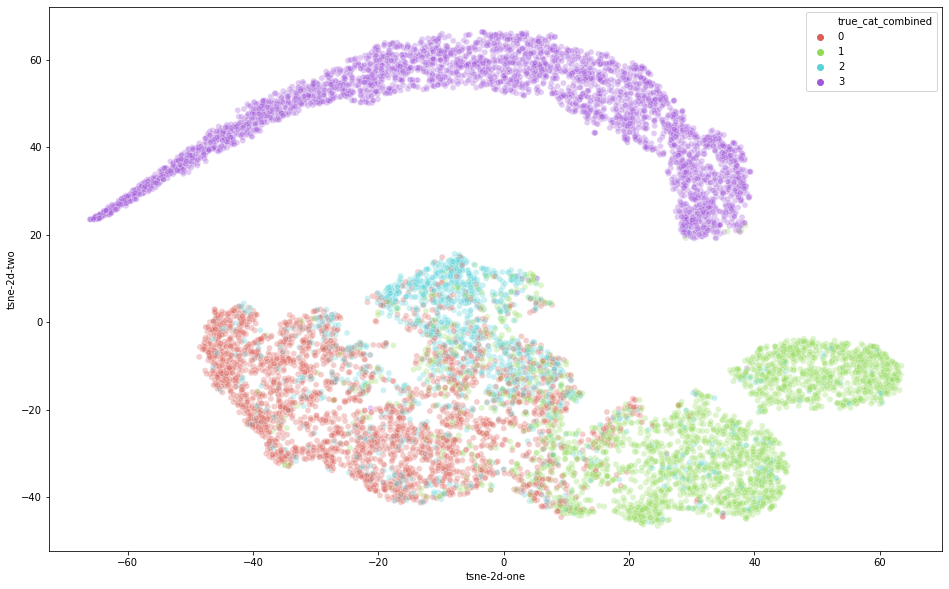

In [22]:
tsne = TSNE(n_components=2, verbose=1, perplexity=100, n_iter=1000, learning_rate=1000.0, early_exaggeration=12.0)
tsne_results_50 = tsne.fit_transform(pca_50_subset)

tsne_50_df = pd.DataFrame(tsne_results_50)
tsne_50_df['true_cat_combined'] = labels_50_subset['true_cat_combined']
tsne_50_df.rename(columns={0: "tsne-2d-one", 1: "tsne-2d-two"}, inplace=True)

plt.figure(figsize=(16,10))
sns.scatterplot(
    x="tsne-2d-one", y="tsne-2d-two",
    hue="true_cat_combined",
    palette=sns.color_palette("hls", 4),
    data=tsne_50_df,
    legend="full",
    alpha=0.3
)